In [1]:
import abeja
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as transforms


IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
ABEJA_TRAINING_RESULT_DIR = os.environ.get('ABEJA_TRAINING_RESULT_DIR', '.')
PATH = os.path.join(ABEJA_TRAINING_RESULT_DIR, 'cifar_net')

In [2]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [3]:
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        return pil_loader(path)

In [4]:
def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [5]:
def has_file_allowed_extension(filename, extensions):
    return filename.lower().endswith(extensions)

In [6]:
def make_dataset(dir, extensions=None, is_valid_file=None):
    dir = os.path.expanduser(dir)
    if not ((extensions is None) ^ (is_valid_file is None)):
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    
    files = []
    for root, _, fnames in sorted(os.walk(dir, followlinks=True)):
        for fname in sorted(fnames):
            path = os.path.join(root, fname)
            if is_valid_file(path):
                files.append(path)
    nb_data = len(files)
    nb_data_per_class = len(files) // 17
    labels = np.arange(nb_data) // nb_data_per_class
    indices = np.arange(nb_data)
    images = [(files[i], labels[i]) for i in indices]
    return labels, indices, images

In [7]:
class FlowerDataset(VisionDataset):
    def __init__(self, root, loader=default_loader,
                 extensions=IMG_EXTENSIONS, transform=None,
                 target_transform=None, is_valid_file=None):
        super(FlowerDataset, self).__init__(root, transform=transform,
                                            target_transform=target_transform)

        classes, targets, samples = make_dataset(self.root, extensions, is_valid_file)
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.targets = targets
        self.samples = samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)

In [8]:
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=64),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
trainset = FlowerDataset(root='/mnt/notebooks/{notebook_id}/data/buckets/{bucket_id}/', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


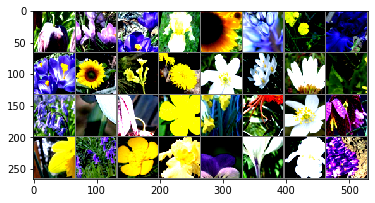

In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 17)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
NUMOF_EPOCHS = int(os.environ.get('NUMOF_EPOCHS', '10'))
NUMOF_EPOCH_BACKUP_INTERVAL = int(os.environ.get('NUMOF_EPOCH_BACKUP_INTERVAL', '5'))


for epoch in range(NUMOF_EPOCHS):
    with abeja.tracking(NUMOF_EPOCHS) as tk:
        running_loss = 0.0
        tk.log_step(epoch+1)
        tk.log_description("Example")
        tk.log_param(key="OPTIMIZER", value="SGD")
        tk.log_param(key="LR", value="0.001")
        tk.log_param(key="MOMENTUM", value="0.9")
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        running_loss = running_loss/(i+1)
        tk.log_metric(key="main/loss", value=running_loss)
        if epoch % NUMOF_EPOCH_BACKUP_INTERVAL == NUMOF_EPOCH_BACKUP_INTERVAL-1:
            print('[epoch %d] loss: %.3f' %
                  (epoch + 1, running_loss))
            torch.save(net.state_dict(), PATH)
            tk.log_artifact(filepath=PATH, delete_flag=True)
        running_loss = 0.0

print('Finished Training')

No output. Need to add "artifact" by "log_artifact()".
No output. Need to add "artifact" by "log_artifact()".
No output. Need to add "artifact" by "log_artifact()".
No output. Need to add "artifact" by "log_artifact()".
[epoch 5] loss: 2.767
step 5
description=Example
params={'OPTIMIZER': 'SGD', 'LR': '0.001', 'MOMENTUM': '0.9'}
metrics={'main_loss': 2.7667626447455826}
artifact=cifar_net
No output. Need to add "artifact" by "log_artifact()".
No output. Need to add "artifact" by "log_artifact()".
No output. Need to add "artifact" by "log_artifact()".
No output. Need to add "artifact" by "log_artifact()".
[epoch 10] loss: 2.271
step 10
description=Example
params={'OPTIMIZER': 'SGD', 'LR': '0.001', 'MOMENTUM': '0.9'}
metrics={'main_loss': 2.271247611489407}
artifact=cifar_net
Finished Training


In [14]:
torch.save(net.state_dict(), PATH)

In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 23 %


In [17]:
class_correct = list(0. for i in range(17))
class_total = list(0. for i in range(17))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(17):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 10 %
Accuracy of     1 : 20 %
Accuracy of     2 : 14 %
Accuracy of     3 :  0 %
Accuracy of     4 : 80 %
Accuracy of     5 :  0 %
Accuracy of     6 : 50 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 : 60 %
Accuracy of    10 :  0 %
Accuracy of    11 :  0 %
Accuracy of    12 : 55 %
Accuracy of    13 :  0 %
Accuracy of    14 : 11 %
Accuracy of    15 : 22 %
Accuracy of    16 : 12 %
